# Step 2: Perform coarse rigid registration

In [1]:
import neuroglancer
from phathom import plotting
import zarr
import os
import matplotlib.pyplot as plt
import numpy as np
from phathom.registration import coarse
from phathom.utils import pickle_save

In [2]:
viewer = neuroglancer.Viewer()
viewer

http://127.0.0.1:33355/v/edf46912e91631385a155f474baf0fc27b4481b0/

Use this in IPython to allow external viewing (from VM)
```
neuroglancer.set_server_bind_address(bind_address='192.168.158.128', bind_port=80)
```

In [3]:
working_dir = '/home/jswaney/coregistration'

In [4]:
fixed_path = 'fixed/zarr_stack/64_64_64'
moving_path = 'moving/zarr_stack/64_64_64'

fixed_store = zarr.NestedDirectoryStore(os.path.join(working_dir, 
                                                     fixed_path))
moving_store = zarr.NestedDirectoryStore(os.path.join(working_dir,
                                                      moving_path))

fixed_down = zarr.load(fixed_store)
moving_down = zarr.load(moving_store)

print('Downsampled shapes:', fixed_down.shape, moving_down.shape)

plotting.plot_both(fixed_down, moving_down, viewer, normalization=1000)

Downsampled shapes: (71, 194, 115) (64, 194, 115)


# Set a threshold for tissue foreground

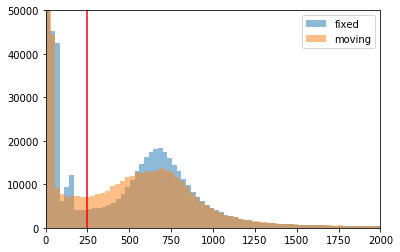

No handles with labels found to put in legend.


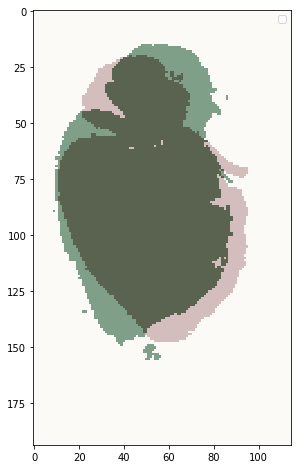

In [15]:
threshold = 250

bins = 256
xmax = 2e3
ymax = 5e4

plt.hist(fixed_down.ravel(), bins, alpha=0.5, label='fixed')
plt.hist(moving_down.ravel(), bins, alpha=0.5, label='moving')
plt.plot([threshold, threshold], [0, ymax], 'r-')
plt.xlim([0, xmax])
plt.ylim([0, ymax])
plt.legend()
plt.show()

fixed_mask = (fixed_down > threshold)
moving_mask = (moving_down > threshold)

plt.figure(figsize=(12, 8))
plt.imshow(fixed_mask[fixed_mask.shape[0] // 2], alpha=0.5, cmap='Reds')
plt.imshow(moving_mask[moving_mask.shape[0] // 2], alpha=0.5, cmap='Greens')
plt.legend()
plt.show()

In [9]:
optim_kwargs = {'niter': 10,
                't0': np.zeros(3),
                'theta0': np.zeros(3)}
min_size = 10
use_hull = False

t_down, theta, center_down = coarse.coarse_registration(moving_down, 
                                                        fixed_down, 
                                                        threshold,
                                                        optim_kwargs,
                                                        min_size=min_size,
                                                        use_hull=use_hull)

basinhopping step 0: f 0.528181
basinhopping step 1: f 0.604992 trial_f 0.604992 accepted 1  lowest_f 0.528181
basinhopping step 2: f 0.569272 trial_f 0.569272 accepted 1  lowest_f 0.528181
basinhopping step 3: f 0.552324 trial_f 0.552324 accepted 1  lowest_f 0.528181
basinhopping step 4: f 0.604443 trial_f 0.604443 accepted 1  lowest_f 0.528181
adaptive stepsize: acceptance rate 0.800000 target 0.500000 new stepsize 1.11111 old stepsize 1
basinhopping step 5: f 0.523507 trial_f 0.523507 accepted 1  lowest_f 0.523507
found new global minimum on step 5 with function value 0.523507
basinhopping step 6: f 0.579947 trial_f 0.579947 accepted 1  lowest_f 0.523507
basinhopping step 7: f 0.547939 trial_f 0.547939 accepted 1  lowest_f 0.523507
basinhopping step 8: f 0.517242 trial_f 0.517242 accepted 1  lowest_f 0.517242
found new global minimum on step 8 with function value 0.517242
basinhopping step 9: f 0.520123 trial_f 0.520123 accepted 1  lowest_f 0.517242
adaptive stepsize: acceptance rat

# Warp downsampled image

In [10]:
registered_down = coarse.rigid_warp(moving_down, 
                                    t_down, 
                                    theta, 
                                    center_down, 
                                    fixed_down.shape)

plotting.plot_both(fixed_down, 
                   registered_down, 
                   viewer, 
                   normalization=2000)

# Convert to fullres transformation

In [11]:
fixed_fullres_path = 'fixed/zarr_stack/1_1_1'
moving_fullres_path = 'moving/zarr_stack/1_1_1'

fixed_fullres_store = zarr.NestedDirectoryStore(os.path.join(working_dir, 
                                                             fixed_fullres_path))
moving_fullres_store = zarr.NestedDirectoryStore(os.path.join(working_dir,
                                                              moving_fullres_path))
fixed_img = zarr.open(fixed_fullres_store, mode='r')
moving_img = zarr.open(moving_fullres_store, mode='r')

true_factors = np.array(fixed_img.shape) / np.array(fixed_down.shape)
t, center = coarse._scale_rigid_params(t_down, 
                                       center_down, 
                                       true_factors)

print('Fullres:', t, center)
print(fixed_img.shape)
print(fixed_down.shape)

Original [   2.90338001 -370.8526147  -191.62759004] [1989.03848673 5334.33099033 3145.78665711]
(4506, 12374, 7337)
(71, 194, 115)


# Save the fullres transformation

In [12]:
rigid_path = 'rigid_transformation.pkl'

transformation_dict = {'t': t,
                       'theta': theta,
                       'center': center}

pickle_save(os.path.join(working_dir, rigid_path), transformation_dict)